In [114]:
import matplotlib
%matplotlib inline
from matplotlib.colors import LogNorm
import yt
from yt.analysis_modules.sunyaev_zeldovich.api import SZProjection
# From http://yt-project.org/doc/analyzing/analysis_modules/sunyaev_zeldovich.html

In [115]:
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.io.fits import getdata
from yt.utilities.cosmology import Cosmology
cosmo = Cosmology()

In [123]:
mean_matter_density = cosmo.critical_density(0.).in_units('g/cm**3') * cosmo.omega_matter
print mean_matter_density.value

2.55673063809e-30


Below, we load in the fits formatted data cubes for temperature, density, and velocity into 256^3 numpy arrays.

In [124]:
T = getdata('/home/babyostrich/data/L500_fits/temperature_a1.0005_CL1_N256_Lv6.fits')
rho = getdata('/home/babyostrich/data/L500_fits/rhogas_a1.0005_CL1_N256_Lv6.fits') * \
    mean_matter_density.value
v = {}
for i in ['x','y','z'] :
    v[i] = getdata('/home/babyostrich/data/L500_fits/v'+i+'_a1.0005_CL1_N256_Lv6.fits')

We then create a yt data structure with the names and units of the data

In [125]:
data = dict(density=(rho,'g/cm**3'),temperature=(T,'K'))
for i in ['x','y','z'] :
    data['velocity_'+i] = (v[i],'km/s')

datastructure = yt.load_uniform_grid(data,(256,256,256),length_unit=256*3.6*(2**3)*3.08567758e21)
dd = datastructure.all_data()

yt : [INFO     ] 2017-06-22 17:42:42,036 Parameters: current_time              = 0.0
yt : [INFO     ] 2017-06-22 17:42:42,037 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2017-06-22 17:42:42,039 Parameters: domain_left_edge          = [ 0.  0.  0.]
yt : [INFO     ] 2017-06-22 17:42:42,041 Parameters: domain_right_edge         = [ 1.  1.  1.]
yt : [INFO     ] 2017-06-22 17:42:42,043 Parameters: cosmological_simulation   = 0.0


As a test, let us render projections of each field

In [126]:
def render_labeled(arr, label=None, label_loc=(1,1), norm=None) :
    plt.imshow(arr, norm=norm)
    if label != None :
        plt.annotate(label, label_loc, color='white', fontsize='xx-large')
    plt.colorbar()

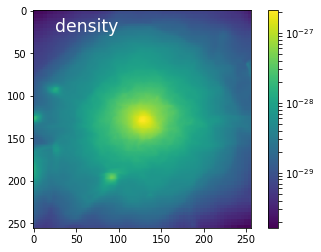

In [127]:
render_labeled(rho.sum(axis=1)/256.,label='density',label_loc=(25,25),norm=LogNorm())

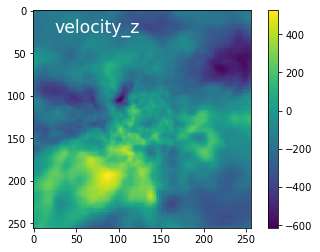

In [95]:
render_labeled(v['y'].sum(axis=1)/256.,label='velocity_z',label_loc=(25,25))

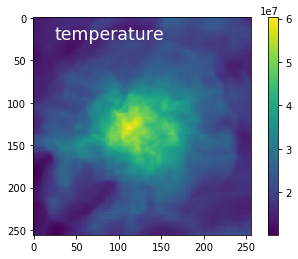

In [94]:
render_labeled(T.sum(axis=1)/256.,label='temperature',label_loc=(25,25))

Now, we can use the temperature, density, and velocities to initialize a yt SZProjection object.  

In [128]:
freqs = [95.,150.,220.]
szprj = SZProjection(datastructure, freqs)

The following step takes ~2-3 minutes to calculate the projection.  We therefore save the calculation in a fits file, which contains a fits image of the SZ signal at each of the specified frequencies, a TeSZ projection, and a Tau projection.

In [129]:
szprj.on_axis('z')

yt : [INFO     ] 2017-06-22 17:43:44,953 Projection completed
yt : [INFO     ] 2017-06-22 17:43:44,954 Making a fixed resolution buffer of (density) 800 by 800
yt : [INFO     ] 2017-06-22 17:43:44,971 Making a fixed resolution buffer of (t_sz) 800 by 800
yt : [INFO     ] 2017-06-22 17:43:46,090 Projection completed
yt : [INFO     ] 2017-06-22 17:43:46,112 Making a fixed resolution buffer of (beta_par) 800 by 800
yt : [INFO     ] 2017-06-22 17:43:48,224 Projection completed
yt : [INFO     ] 2017-06-22 17:43:48,248 Making a fixed resolution buffer of (t_squared) 800 by 800
yt : [INFO     ] 2017-06-22 17:43:49,629 Projection completed
Computing SZ signal.: 100%|██████████| 640000/640000 [02:06<00:00, 5066.83it/s]


In [130]:
szprj.write_fits('/home/babyostrich/data/L500_fits/szprjz_a1.0005_CL1_N256_Lv6.fits',clobber=True)

yt : [INFO     ] 2017-06-22 17:46:01,973 Making a FITS image of field 150_GHz
yt : [INFO     ] 2017-06-22 17:46:01,979 Making a FITS image of field 220_GHz
yt : [INFO     ] 2017-06-22 17:46:01,982 Making a FITS image of field 95_GHz
yt : [INFO     ] 2017-06-22 17:46:01,984 Making a FITS image of field TeSZ
yt : [INFO     ] 2017-06-22 17:46:01,987 Making a FITS image of field Tau


In [131]:
sz_z = fits.open('/home/babyostrich/data/L500_fits/szprjz_a1.0005_CL1_N256_Lv6.fits')

In [132]:
sz_z.info()

Filename: /home/babyostrich/data/L500_fits/szprjz_a1.0005_CL1_N256_Lv6.fits
No.    Name         Type      Cards   Dimensions   Format
  0  150_GHZ     PrimaryHDU      21   (800, 800)   float64   
  1  220_GHZ     ImageHDU        22   (800, 800)   float64   
  2  95_GHZ      ImageHDU        22   (800, 800)   float64   
  3  TESZ        ImageHDU        22   (800, 800)   float64   
  4  TAU         ImageHDU        22   (800, 800)   float64   


We can also directly access each of the projections from the SZProjection object as dictionary items.  NOTE: I'm not sure what the units on all of these are.  TeSZ looks like it could be log temperature in Kelvin.

In [133]:
szprj.keys()

['150_GHz', '220_GHz', '95_GHz', 'TeSZ', 'Tau']

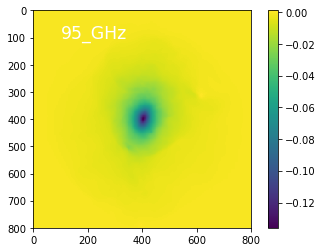

In [137]:
render_labeled(szprj['95_GHz'],label='95_GHz',label_loc=(100,100))

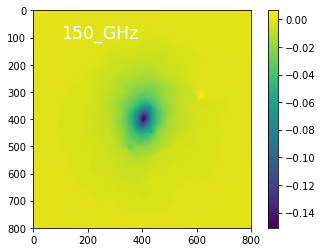

In [138]:
render_labeled(szprj['150_GHz'],label='150_GHz',label_loc=(100,100))

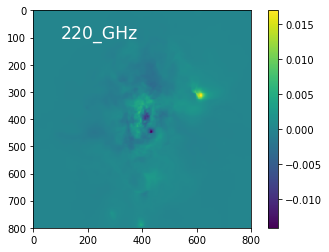

In [139]:
render_labeled(szprj['220_GHz'],label='220_GHz',label_loc=(100,100))

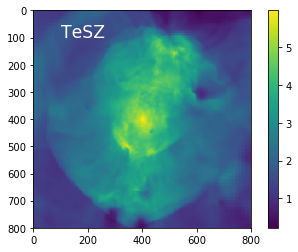

In [140]:
render_labeled(szprj['TeSZ'],label='TeSZ',label_loc=(100,100))

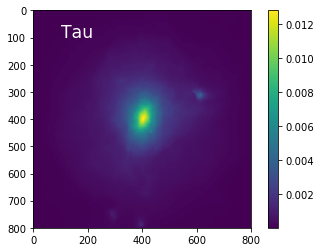

In [143]:
render_labeled(szprj['Tau'],label='Tau',label_loc=(100,100))